In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import random

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

NEURAL NET

In [3]:
class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)


In [4]:
def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(20 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    x_train = x_[:training_size, :]
    y_train = y_[:training_size, :]

    x_val = x_[training_size:, :]
    y_val = y_[training_size:, :]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    #y_test_pred = my_network(x_test).reshape(-1, )
    y_val_pred = my_network(x_val).reshape(-1, )
    y_train_pred = my_network(x_train).reshape(-1, )

    # Compute the relative training error
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

    # Compute the relative validation error
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")

    return relative_error_train.item(), relative_error_val.item(), my_network

In [5]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

DATA AND DETAILS

32 RANDOM ELEMENTS AS VALIDATION

In [6]:
sampling_seed = 74
torch.manual_seed(sampling_seed)

data101 = np.loadtxt('TrainingData_101.txt', delimiter=' ')
data401 = np.loadtxt('TrainingData_401.txt', delimiter=' ')
data1601 = np.loadtxt('TrainingData_1601.txt', delimiter=' ')
sobol = np.loadtxt('samples_sobol.txt', delimiter=' ')

datasets_meshes=[]
datasets_meshes.append(data101)
datasets_meshes.append(data401)
datasets_meshes.append(data1601)

valid_index = random.sample(range(160), 32)
training_sets = list()
# save min a max of details to detransform the output after NN
minima_det = list()
maxima_det = list()

data_validation = np.concatenate([sobol[valid_index,:], data1601[valid_index,8].reshape(-1,1)], 1)
ts_detail_l = np.concatenate([np.delete(sobol, valid_index, 0), np.delete(data101, valid_index, 0)[:,8].reshape(-1,1)], 1)
training_sets.append(ts_detail_l)

# Obtain the details at different mesh resolutions
# can try different normalizations for the two details
for l in range(1, 3):
    ns = datasets_meshes[l].shape[0]
    obs_difff = datasets_meshes[l][:ns, -1] - datasets_meshes[l - 1][:ns, -1]
    obs_diff = np.delete(obs_difff, valid_index)
    ts_detail_l = np.concatenate([np.delete(sobol, valid_index, 0)[:ns-32, :8], obs_diff.reshape(-1, 1)], 1)
    for i in range(8,9):
        minima_det.append(min(ts_detail_l[:,i]))
        maxima_det.append(max(ts_detail_l[:,i]))
        #ts_detail_l[:,i] = (ts_detail_l[:,i] - np.mean(ts_detail_l[:,i])) / np.std(ts_detail_l[:,i])
        ts_detail_l[:,i] = (ts_detail_l[:,i] - min(ts_detail_l[:,i])) / (max(ts_detail_l[:,i])-min(ts_detail_l[:,i]))
    training_sets.append(ts_detail_l)

#normalize or not the first output
#for i in range(8,9):
    #training_sets[0][:,i] = (training_sets[0][:,i] - min(training_sets[0][:,i])) / (max(training_sets[0][:,i])-min(training_sets[0][:,i]))


In [7]:
for i in range(3):
    print(training_sets[i].shape)


(2528, 9)
(608, 9)
(128, 9)


FIRST 32 ELEMENTS AS VALIDATION

In [9]:
# Random Seed for dataset generation
sampling_seed = 74
torch.manual_seed(sampling_seed)

data101 = np.loadtxt('TrainingData_101.txt', delimiter=' ')
data401 = np.loadtxt('TrainingData_401.txt', delimiter=' ')
data1601 = np.loadtxt('TrainingData_1601.txt', delimiter=' ')
sobol = np.loadtxt('samples_sobol.txt', delimiter=' ')

datasets_meshes=[]
datasets_meshes.append(data101)
datasets_meshes.append(data401)
datasets_meshes.append(data1601)

training_sets = list()
# save min a max of details to detransform the output after NN
minima_det = list()
maxima_det = list()
data_validation = np.concatenate([sobol[:32,:], data1601[:32,8].reshape(-1,1)], 1)
ts_detail_l=np.concatenate([sobol[32:,:], data101[32:,8].reshape(-1,1)], 1)
training_sets.append(ts_detail_l)

# Obtain the details at different mesh resolutions
# can try different normalizations for the two details
for l in range(1, 3):
    ns = datasets_meshes[l].shape[0]
    obs_diff = datasets_meshes[l][32:ns, -1] - datasets_meshes[l - 1][32:ns, -1]
    ts_detail_l = np.concatenate([sobol[32:ns, :8], obs_diff.reshape(-1, 1)], 1)
    for i in range(8,9):
        minima_det.append(min(ts_detail_l[:,i]))
        maxima_det.append(max(ts_detail_l[:,i]))
        #ts_detail_l[:,i] = (ts_detail_l[:,i] - np.mean(ts_detail_l[:,i])) / np.std(ts_detail_l[:,i])
        ts_detail_l[:,i] = (ts_detail_l[:,i] - min(ts_detail_l[:,i])) / (max(ts_detail_l[:,i])-min(ts_detail_l[:,i]))
    training_sets.append(ts_detail_l)

#normalize or not the first output
#for i in range(8,9):
    #training_sets[0][:,i] = (training_sets[0][:,i] - min(training_sets[0][:,i])) / (max(training_sets[0][:,i])-min(training_sets[0][:,i]))

In [8]:
#sobol is just the normalization of this
data101[:,0] = (data101[:,0] - min(data101[:,0])) / (max(data101[:,0])-min(data101[:,0]))
print(data101[:10,0])
print(sobol[:10,0])

[0.5        0.75024438 0.24975562 0.37487781 0.87536657 0.62512219
 0.12463343 0.18719453 0.68768328 0.93792766]
[0.5    0.75   0.25   0.375  0.875  0.625  0.125  0.1875 0.6875 0.9375]


FIRST MODEL

In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [25, 30],
        "regularization_exp": [2],
        "regularization_param": [0, 1e-4],
        "batch_size": [2560],
        "epochs": [2000],
        "optimizer": ["LBFGS"],
        "init_weight_seed": [567, 1000, 134],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

train_err_conf = list()
val_err_conf = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_net = run_single_configuration(setup_properties, torch.from_numpy(training_sets[0][:, :8]).type(torch.float32), torch.from_numpy(training_sets[0][:, -1].reshape(-1, 1)).type(torch.float32))
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)

SECOND MODEL

In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [25, 20],
        "regularization_exp": [2],
        "regularization_param": [1e-4, 3e-4],
        "batch_size": [640],
        "epochs": [1000],
        "optimizer": ["LBFGS"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [567, 340],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

train_err_conf2 = list()
val_err_conf2 = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_net = run_single_configuration(setup_properties, torch.from_numpy(training_sets[1][:, :8]).type(torch.float32), torch.from_numpy(training_sets[1][:, -1].reshape(-1, 1)).type(torch.float32))
    train_err_conf2.append(relative_error_train_)
    val_err_conf2.append(relative_error_val_)

train_err_conf2 = np.array(train_err_conf2)
val_err_conf2 = np.array(val_err_conf2)

THIRD MODEL

In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [20, 25],
        "regularization_exp": [0],
        "regularization_param": [1e-4, 3e-4],
        "batch_size": [16],
        "epochs": [1500],
        "optimizer": ["ADAM"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [567, 34],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

train_err_conf3 = list()
val_err_conf3 = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_net = run_single_configuration(setup_properties, torch.from_numpy(training_sets[2][:, :8]).type(torch.float32), torch.from_numpy(training_sets[2][:, -1].reshape(-1, 1)).type(torch.float32))
    train_err_conf3.append(relative_error_train_)
    val_err_conf3.append(relative_error_val_)

train_err_conf3 = np.array(train_err_conf3)
val_err_conf3 = np.array(val_err_conf3)

CHOOSE THE MODEL

In [ ]:
print(np.where(val_err_conf==min(val_err_conf)))
print(np.where(val_err_conf2==min(val_err_conf2)))
print(np.where(val_err_conf3==min(val_err_conf3)))

RUN MODEL 1

In [7]:
approximate_models = list()
setup_properties = {
        "hidden_layers": 2,
        "neurons": 30,
        "regularization_exp": 2,
        "regularization_param": 0,
        "batch_size": 2560,
        "epochs": 2000,
        "optimizer": "LBFGS",
        "init_weight_seed": 567,
        "activation": "tanh"
    }

relative_error_train_, relative_error_val_, my_network1 = run_single_configuration(setup_properties, torch.from_numpy(training_sets[0][:, :8]).type(torch.float32), torch.from_numpy(training_sets[0][:, -1].reshape(-1, 1)).type(torch.float32))
approximate_models.append(my_network1)

{'hidden_layers': 2, 'neurons': 30, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 2560, 'epochs': 2000, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  2.21e-06
Final Validation Loss:  2.47e-06
Relative Training Error:  0.3557519055902958 %
Relative Validation Error:  0.37645292468369007 %


RUN MODEL 2

  "hidden_layers": 2,
        "neurons": 25,
        "regularization_exp": 2,
        "regularization_param": 1e-4,
        "batch_size": 64,
        "epochs": 1000,
        "optimizer": "ADAM",
        "init_weight_seed": 567,
        "activation": "tanh"
    }

In [8]:
setup_properties = {
        "hidden_layers": 0,
        "neurons": 25,
        "regularization_exp": 2,
        "regularization_param": 1e-4,
        "batch_size": 64,
        "epochs": 2000,
        "optimizer": "ADAM",
        "init_weight_seed": 340,
        "activation": "tanh"
    }

relative_error_train_, relative_error_val_, my_network2 = run_single_configuration(setup_properties, torch.from_numpy(training_sets[1][:, :8]).type(torch.float32), torch.from_numpy(training_sets[1][:, -1].reshape(-1, 1)).type(torch.float32))
approximate_models.append(my_network2)

{'hidden_layers': 0, 'neurons': 25, 'regularization_exp': 2, 'regularization_param': 0.0001, 'batch_size': 64, 'epochs': 2000, 'optimizer': 'ADAM', 'init_weight_seed': 340, 'activation': 'tanh'}
Simple linear regression
Final Training Loss:  0.01570153
Final Validation Loss:  0.01979657
Relative Training Error:  28.349989652633667 %
Relative Validation Error:  31.646350026130676 %


RUN MODEL 3

        "hidden_layers": 8,
        "neurons": 10,
        "regularization_exp": 0,
        "regularization_param": 0,
        "batch_size": 16,
        "epochs": 1000,
        "optimizer":  "ADAM",
        "init_weight_seed": 34,
        "activation": "relu"

In [9]:
setup_properties = {
        "hidden_layers": 1,
        "neurons": 20,
        "regularization_exp": 0,
        "regularization_param": 1e-4,
        "batch_size": 16,
        "epochs": 2000,
        "optimizer":  "ADAM",
        "init_weight_seed": 567,
        "activation": "tanh"
    }

relative_error_train_, relative_error_val_, my_network3 = run_single_configuration(setup_properties, torch.from_numpy(training_sets[2][:, :8]).type(torch.float32), torch.from_numpy(training_sets[2][:, -1].reshape(-1, 1)).type(torch.float32))
approximate_models.append(my_network3)

{'hidden_layers': 1, 'neurons': 20, 'regularization_exp': 0, 'regularization_param': 0.0001, 'batch_size': 16, 'epochs': 2000, 'optimizer': 'ADAM', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  0.03177037
Final Validation Loss:  0.04855589
Relative Training Error:  23.816367983818054 %
Relative Validation Error:  52.070796489715576 %


ACCURACY

In [10]:
def predict_with_ml(list_models, inputs_, minima, maxima):
    output_ = torch.zeros(inputs_.shape[0], 1)
    output_ = output_ + list_models[0](inputs_)
    for i in range(1,3):
        output_ = output_ + list_models[i](inputs_)*(maxima[i-1]-minima[i-1]) + minima[i-1]
    return output_


x_predict_train = torch.from_numpy(np.delete(sobol, valid_index, 0)[:128,:8]).type(torch.float32)
print(x_predict_train.shape)
x_predict_valid = torch.from_numpy(data_validation[:,:8]).type(torch.float32)
print(x_predict_valid.shape)
y_predict_ml_train = predict_with_ml(approximate_models, x_predict_train ,minima_det, maxima_det).reshape(-1, 1)
y_predict_ml_valid = predict_with_ml(approximate_models, x_predict_valid ,minima_det, maxima_det).reshape(-1, 1)

real_val_train = torch.from_numpy(np.delete(data1601, valid_index, 0)[:,8]).type(torch.float32).reshape(-1, 1)
real_val_valid = torch.from_numpy(data_validation[:,8]).type(torch.float32).reshape(-1, 1)
relative_error_train = torch.mean((y_predict_ml_train - real_val_train) ** 2) / torch.mean(real_val_train ** 2)
relative_error_valid = torch.mean((y_predict_ml_valid - real_val_valid) ** 2) / torch.mean(real_val_valid ** 2)
print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")
print("Relative Validation Error: ", relative_error_valid.detach().numpy() ** 0.5 * 100, "%")

torch.Size([128, 8])
torch.Size([32, 8])
Relative Training Error:  0.2739792689681053 %
Relative Validation Error:  0.35279830917716026 %


PLOT

Text(0, 0.5, 'temp 0')

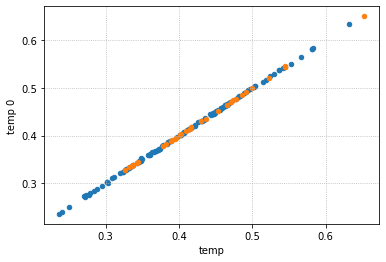

In [13]:
plt.grid(True, which="both", ls=":")
plt.scatter(real_val_train.detach(),y_predict_ml_train.detach(), s=20)
plt.scatter(real_val_valid.detach(),y_predict_ml_valid.detach(), s=20)
#train_pred_ml.detach()
plt.xlabel("temp")
plt.ylabel("temp 0")

PREDICTIONS

In [14]:
test_data = np.loadtxt('TestingData.txt', delimiter=' ')

In [15]:
y_predict_test = predict_with_ml(approximate_models, torch.from_numpy(test_data).type(torch.float32) ,minima_det, maxima_det).reshape(-1, 1)


PLOT THE PREDICTIONS

SAVE THE PREDICTIONS IN A TXT FILE

In [17]:
PATH="Task2\Submission"

predictions_test=y_predict_test.detach().numpy()

np.savetxt("angelo_gnazzo_secondo.txt", predictions_test, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)